In [2]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import moss
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.display import Image

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
%matplotlib inline

In [5]:
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subjects = list(np.loadtxt(subj_file,'string'))
subjects_dir = home_dir + 'data/freesurfer/'

In [55]:
#initialize workflow
wf = Workflow('freesurfer_recon')
wf.base_dir = abspath(home_dir)

In [56]:
#get data using datagrabber
##set up data grabber
ds = Node(DataGrabber(infields=['subject_id','task_id','run_id'],outfields =['func','anat']),
         name = 'datasource')
ds.inputs.base_directory = abspath(home_dir + '/data/')
ds.inputs.template = '*'
ds.inputs.template_args = {'anat':[['subject_id']]}
ds.inputs.field_template = {'anat': '%s/anat/st1_0000.nii'}
ds.inputs.sort_filelist = True

ds.inputs.subject_id = subjects
ds.inputs.task_id = '*'
ds.inputs.run_id = '*'
print ds.run().outputs

INFO:workflow:Executing node datasource in dir: /tmp/tmpBPneVt/datasource



anat = ['/data/home/iballard/mag/data/subject03/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject04/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject05/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject06/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject08/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject09/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject10/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject11/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject12/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject13/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject14/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject20/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject21/anat/st1_0000.nii', '/data/home/iballard/mag/data/subject22/anat/st1_0000.nii']



In [57]:
#set up recon node
recon_all = MapNode(interface = ReconAll(), name = 'recon_all',iterfield = ['subject_id','T1_files'])
recon_all.inputs.subject_id  = subjects
recon_all.inputs.subjects_dir = subjects_dir
recon_all.inputs.directive  = 'autorecon3'
# recon_all.inputs.args = '-noskullstrip'
wf.connect(ds,'anat',recon_all,'T1_files')
print recon_all.inputs


T1_files = <undefined>
T2_file = <undefined>
args = <undefined>
directive = autorecon3
environ = {}
flags = <undefined>
hemi = <undefined>
ignore_exception = False
openmp = <undefined>
subject_id = ['subject03', 'subject04', 'subject05', 'subject06', 'subject08', 'subject09', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject20', 'subject21', 'subject22']
subjects_dir = /data/home/iballard/mag/data/freesurfer/
terminal_output = stream



In [39]:
# wf.run(plugin = 'MultiProc')

In [62]:
##fix directory structure. For some reason ipython insists on making a new directory for freesurfer outputs,
#but lyman wants them in the subject folder
for n,sub in enumerate(subjects):
    if n > 0:
        freesurfer_dir = home_dir + '/data/freesurfer/' + sub
        if os.path.exists(freesurfer_dir):
            sub_dir = home_dir + '/data/' + sub +'/'
            cmd = 'mv ' + freesurfer_dir + '/* ' + sub_dir
            os.system(cmd)
            os.rmdir(freesurfer_dir)


In [64]:
for n,s in enumerate(subjects):
    if n>0:
        path = home_dir + '/data/' + s + '/mri/'
        old = path + 'T1.mgz'
        new = path +'brainmask.auto.mgz'
        os.remove(new)
        cmd = ['ln','-s',old,new]
        cmd = ' '.join(cmd)
        os.system(cmd)

        old = path +'brainmask.auto.mgz'
        new = path +'brainmask.mgz'
        os.remove(new)
        cmd = ['ln','-s',old,new]
        cmd = ' '.join(cmd)
        os.system(cmd)

In [19]:
from moss.mosaic import Mosaic
# from nipy import VolumeImg

p = home_dir + '/analysis/workingdir/mag/preproc/'
mask = p + 'skullstrip/_subject_id_subject03/convertmask/mapflow/_convertmask0/'
mask_img = mask +'functional_mask.nii.gz'
# print nib.load(mask).shape
# print nib.load(mask)
mean = p + 'skullstrip/_subject_id_subject03/stripmean/mapflow/_stripmean0/'
mean = mean + 'timeseries_mcf_mean_masked.nii.gz'

orig = p + 'skullstrip/_subject_id_subject03/origmean/mapflow/_origmean0/'
orig = orig + 'timeseries_mcf_mean.nii.gz'


# mask_img = VolumeImg(mask_img.get_data().astype(bool),
#                           mask_img.get_affine(),
#                           world_space="mni",
#                           interpolation="nearest",
#                           ).xyz_ordered(resample=True)
print nib.load(mask_img).get_affine()

print nib.load(orig).get_affine()
mask = mask_img.get_data()
orig = nib.load(orig).get_data()

# print nib.load(orig)
# a = nib.load(mask).shape
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True,
                                     light=1, dark=0)
# m = Mosaic(orig,mask, mask,step = 1)
# m.plot_mask()

[[ -1.   0.   0.  32.]
 [  0.   0.   1. -15.]
 [  0.  -1.   0.  32.]
 [  0.   0.   0.   1.]]
[[ -3.           0.           0.          94.5       ]
 [  0.           3.           0.         -94.5       ]
 [  0.           0.           3.99000001 -57.85500014]
 [  0.           0.           0.           1.        ]]


AttributeError: 'str' object has no attribute 'get_data'

In [11]:
mask.shape
orig.shape

(64, 64, 30)

In [4]:
print nib.load(mask).shape
print nib.load(orig).shape
m = Mosaic(orig,mask,mask, step = 1)


NameError: name 'mask' is not defined

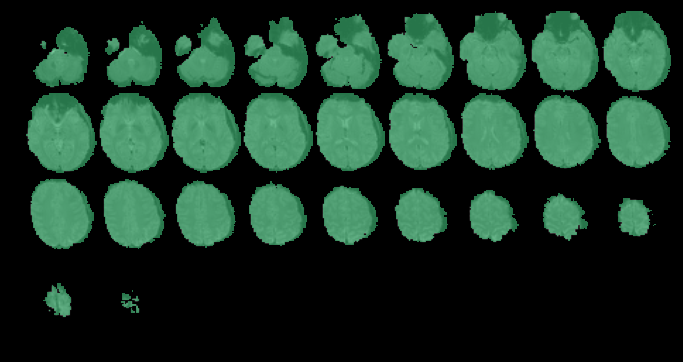

In [23]:
from moss.mosaic import Mosaic
# from nipy import VolumeImg

p = home_dir + '/analysis/mag/subject08/preproc/run_4/'
mask_img = p + 'functional_mask.nii.gz'

mean = p + 'mean_func.nii.gz'



mask = nib.load(mask_img).get_data()
mean = nib.load(mean).get_data()

# print nib.load(orig)
# a = nib.load(mask).shape
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True,
                                     light=1, dark=0)
m = Mosaic(mean,mask, mask,step = 1)
m.plot_mask()